# Lib loading


In [104]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [105]:
url = "https://raw.githubusercontent.com/AnnaRemi/Lab_trajectiories/main/_sessions/Anna_circle/SM2_B1A104.csv"
dataset = pd.read_csv(url)

In [106]:
dataset.head()

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
0,-0.021240,0.014526,0.997559,1.937866,-2.197266,3.326416
1,-0.021484,0.014404,0.997559,1.739502,-1.770020,2.532959
2,-0.020386,0.015625,0.997559,1.571655,-1.419067,1.922607
3,-0.020386,0.015991,0.998413,1.083374,-0.854492,1.403809
4,-0.020996,0.016235,0.999756,0.610352,-0.289917,0.991821


# Integration function


Here I'm going to approximate an integral by rectangles beneath the curve


In [107]:
def integrate(data, times):
    accumulated_speed = 0.0

    last_time = times[0]
    speeds = []

    for i in range(1, len(times)):
        time = times[i]

        delta_t = time - last_time
        delta_v = data[i] * delta_t

        accumulated_speed += delta_v

        speeds.append(accumulated_speed)
        last_time = time
    return speeds

# Gyro data explored

In [108]:
YAW_RATES = [dataset.gyro_x, dataset.gyro_y, dataset.gyro_z]
TIMESTAMPS    = np.arange(0, dataset.accel_z.size, 1)

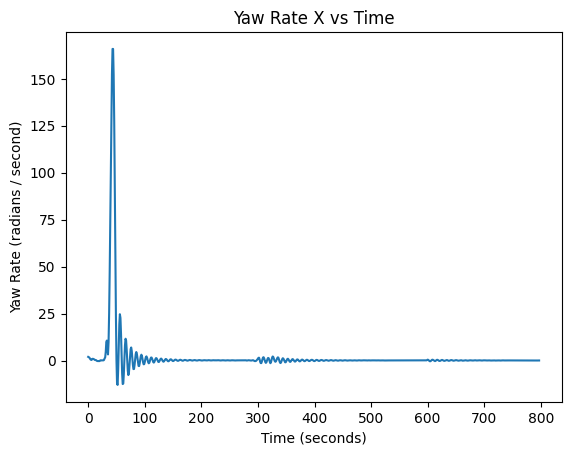

In [109]:
plt.title("Yaw Rate X vs Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Yaw Rate (radians / second)")
plt.plot(TIMESTAMPS, YAW_RATES[0])
plt.show()

In [110]:
def get_angle(YAW_RATES, TIMESTAMPS):
  thetas_x = integrate(YAW_RATES[0], TIMESTAMPS)
  thetas_y = integrate(YAW_RATES[1], TIMESTAMPS)
  thetas_z = integrate(YAW_RATES[2], TIMESTAMPS)

  ANGLES = [thetas_x, thetas_y, thetas_z]
  return ANGLES

In [111]:
ANGLES = get_angle(YAW_RATES, TIMESTAMPS)

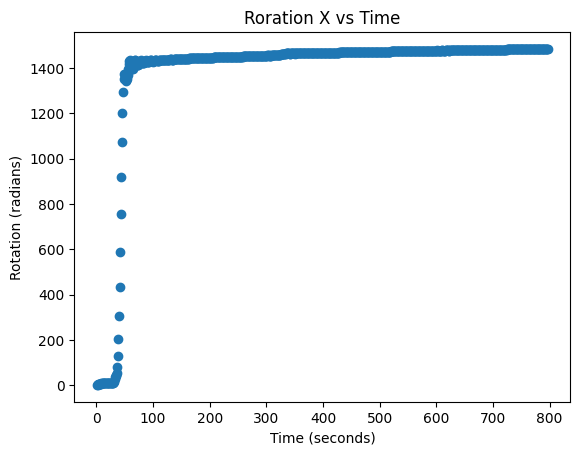

In [112]:
plt.title("Roration X vs Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Rotation (radians)")
plt.scatter(TIMESTAMPS[1:], ANGLES[0])
plt.show()

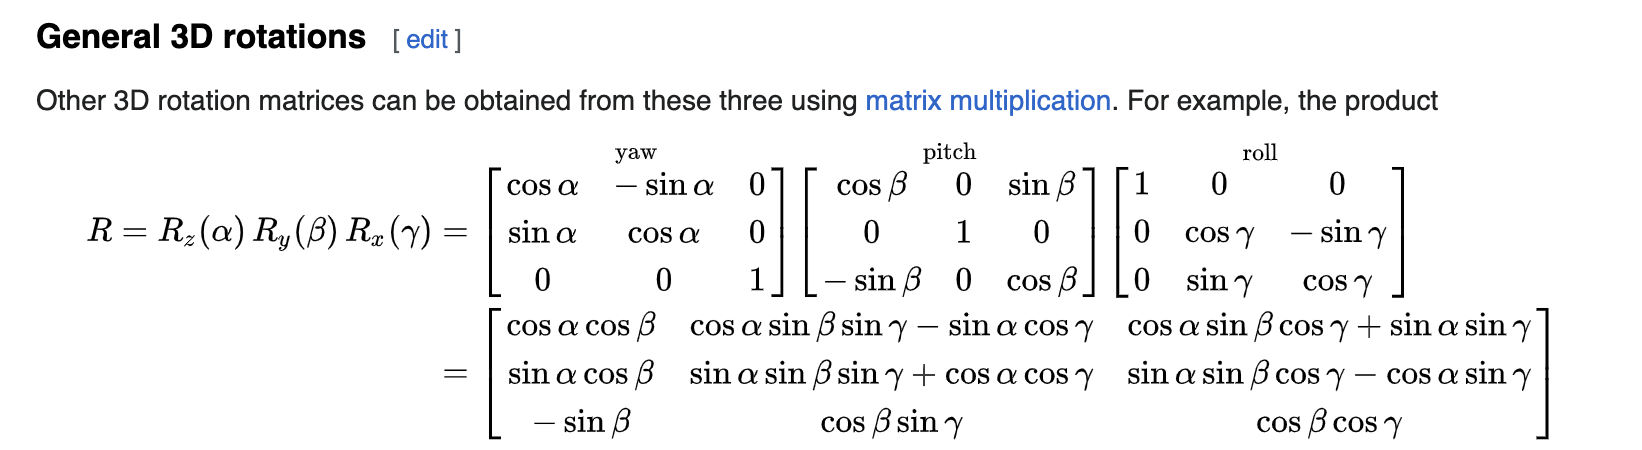

In [113]:
#calculate rotation matrix for each measurement
#calculation is done according to the image from wikipedia above

def get_rotation_matr(ANGLES):
  MATRICES = []

  for i in range(len(ANGLES[0])):
    alpha = (ANGLES[0][i]) #x
    beta = (ANGLES[1][i]) #y
    gamma = (ANGLES[2][i]) #z

    c_a, s_a = np.cos(alpha), np.sin(alpha)
    # R_x = np.array([[1, 0, 0], [0, c_a, -s_a], [0, s_a, c_a]])

    c_b, s_b = np.cos(beta), np.sin(beta)
    # R_y = np.array([[c_b, 0, s_b], [0, 1, 0], [-s_b, 0, c_b]])

    c_g, s_g = np.cos(gamma), np.sin(gamma)
    # R_z = np.array([[c_g, -s_g, 0], [s_g, c_g, 0], [0, 0, 1]])

    R = [[c_b*c_g, s_a*s_b*c_g - c_a*s_g, c_a*s_b*c_g + s_a*s_g],
         [c_b*s_g, s_a*s_b*s_g + c_a*c_g, c_a*s_b*s_g - s_a*c_g],
         [-s_b, s_a*c_b, c_a*c_b]]

    #MATRICES.append((R_z.dot(R_y)).dot(R_x))
    MATRICES.append(R)

  return MATRICES

# Gyro and Accelerometer data combined

In [114]:
#calculate new accelerations by multiplying rotation matrix by acceleration vector

def callibrate(ACCELERATIONS, YAW_RATES, TIMESTAMPS):
  ANGLES = get_angle(YAW_RATES, TIMESTAMPS)
  MATRICES = get_rotation_matr(ANGLES)

  new_acc = [[], [], []]

  for i in range(len(MATRICES)):
    matrix = np.array(MATRICES[i])
    vector = np.array([ACCELERATIONS[0][i], ACCELERATIONS[1][i], ACCELERATIONS[2][i]])
    res = (matrix.dot(vector)).tolist()
    new_acc[0].append(res[0])
    new_acc[1].append(res[1])
    new_acc[2].append(res[2] - 1) #subtracting g(ravity) from accelerometer measurements

  return new_acc

In [115]:
#get position for the sensor by double integrating accelerations from the previous step

def get_position(ACCELERATIONS, TIMESTAMPS):
  # Now we use the function we just defined
  integrated_speeds_x = integrate(ACCELERATIONS[0], TIMESTAMPS)
  integrated_displ_x = integrate(integrated_speeds_x,
                                                  TIMESTAMPS[1:])

  integrated_speeds_y = integrate(ACCELERATIONS[1], TIMESTAMPS)
  integrated_displ_y = integrate(integrated_speeds_y,
                                                  TIMESTAMPS[1:])

  integrated_speeds_z = integrate(ACCELERATIONS[2], TIMESTAMPS)
  integrated_displ_z = integrate(integrated_speeds_z,
                                                  TIMESTAMPS[1:])

  position = [integrated_displ_x, integrated_displ_y, integrated_displ_z]
  return position


# Histogram and trajectory from data


In [116]:
def scale(df):
  # return (df - df.min()) / (df.max() - df.min())
  return (df - df.mean())/df.std()

In [117]:
def get_hist_and_traj(ACCELERATIONS, YAW_RATES, TIMESTAMPS):
    ACCELERATIONS_NEW = callibrate(ACCELERATIONS, YAW_RATES, TIMESTAMPS)
    POSITIONS = get_position(ACCELERATIONS_NEW, TIMESTAMPS[1:])

    df_x = pd.DataFrame({'accelerations':ACCELERATIONS_NEW[0][2:],
                   'positions':POSITIONS[0]})
    df_x = scale(df_x)

    df_y = pd.DataFrame({'accelerations':ACCELERATIONS_NEW[1][2:],
                   'positions':POSITIONS[1]})
    df_y = scale(df_y)

    df_z = pd.DataFrame({'accelerations':ACCELERATIONS_NEW[2][2:],
                   'positions':POSITIONS[2]})
    df_z = scale(df_z)


    bins = 5
    fig_1 = plt.figure(figsize=(5,4))
    fig_1.suptitle('Trajectory')
    ax = fig_1.add_subplot(111, projection='3d')
    ax.plot3D(POSITIONS[0], POSITIONS[1], POSITIONS[2])

    fig_2 = plt.figure(figsize=(9,3))
    fig_2.suptitle('Acceleration and position hists')
    x = fig_2.add_subplot(131)
    x.hist(df_x['accelerations'], bins, alpha=0.5, label='x accel')
    x.hist(df_x['positions'], bins, alpha=0.5, label='x pos')
    x.legend()

    y = fig_2.add_subplot(132)
    y.hist(df_y['accelerations'], bins, alpha=0.5, label='y accel')
    y.hist(df_y['positions'], bins, alpha=0.5, label='y pos')
    y.legend()

    z = fig_2.add_subplot(133)
    z.hist(df_z['accelerations'], bins, alpha=0.5, label='z accel')
    z.hist(df_z['positions'], bins, alpha=0.5, label='z pos')
    z.legend()

    plt.show()

# Plotting some trajectories and hists

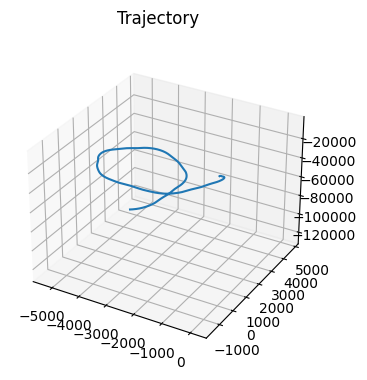

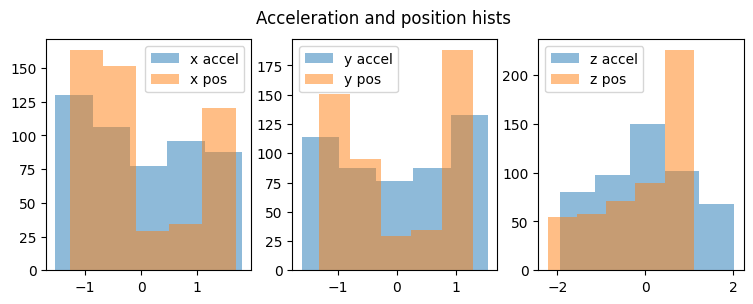

In [118]:
url = "https://raw.githubusercontent.com/AnnaRemi/Lab_trajectiories/main/_sessions/Anna_circle/SM2_B1A105.csv"
dataset = pd.read_csv(url)
dataset = dataset[:500]

TIMESTAMPS    = np.arange(0, dataset.accel_z.size, 1)
YAW_RATES = [dataset.gyro_x, dataset.gyro_y, dataset.gyro_z]
ACCELERATIONS = [dataset.accel_x, dataset.accel_y, dataset.accel_z]

get_hist_and_traj(ACCELERATIONS, YAW_RATES, TIMESTAMPS)

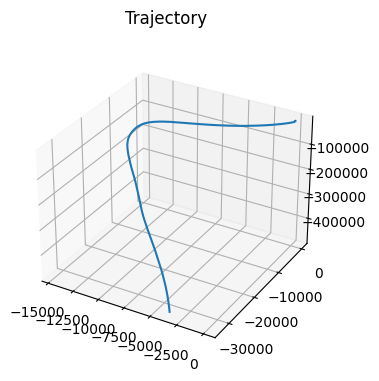

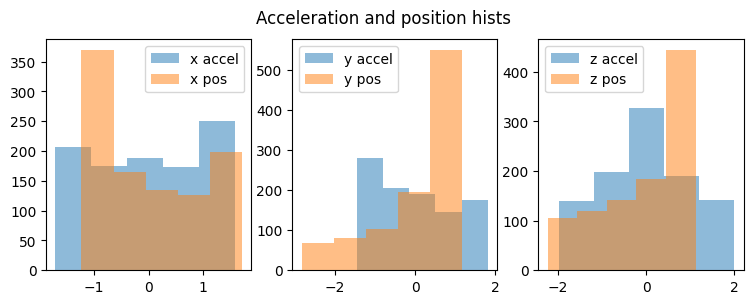

In [119]:
url = "https://raw.githubusercontent.com/AnnaRemi/Lab_trajectiories/main/_sessions/Test/SM1_B1A105.csv"
dataset = pd.read_csv(url)

TIMESTAMPS    = np.arange(0, dataset.accel_z.size, 1)
YAW_RATES = [dataset.gyro_x, dataset.gyro_y, dataset.gyro_z]
ACCELERATIONS = [dataset.accel_x, dataset.accel_y, dataset.accel_z]

get_hist_and_traj(ACCELERATIONS, YAW_RATES, TIMESTAMPS)

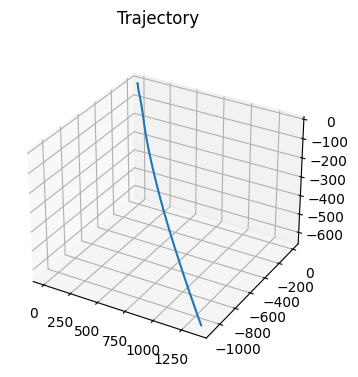

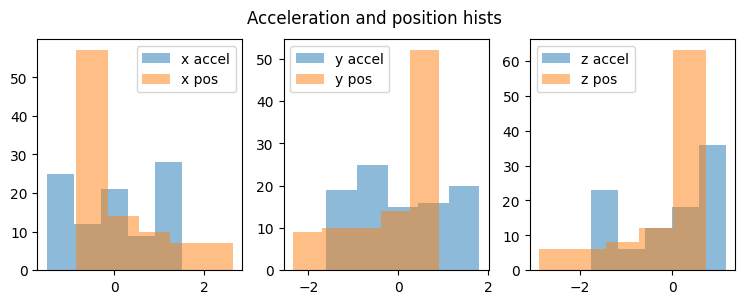

In [120]:
url = "https://raw.githubusercontent.com/AnnaRemi/Lab_trajectiories/main/_sessions/test_2/SM1_B1A104.csv"
dataset = pd.read_csv(url)

TIMESTAMPS    = np.arange(0, dataset.accel_z.size, 1)
YAW_RATES = [dataset.gyro_x, dataset.gyro_y, dataset.gyro_z]
ACCELERATIONS = [dataset.accel_x, dataset.accel_y, dataset.accel_z]

get_hist_and_traj(ACCELERATIONS, YAW_RATES, TIMESTAMPS)

# Logistic regression

In [121]:
def sigmoid(x):
  return 1.0 / (1 + np.exp(-x))

In [122]:
def predict(features, weights):
  return sigmoid(np.dot(features, weights))

***LogLoss/CrossEntropyLoss: <br/>***
$-\frac{1}{m} \sum_{i=1}^{m} (y_i * \ln p_i + (1 - y_i) \ln (1 - p_i))$ <br/>
where $y_i$ is probability of the ith class(out of m) in target and $p_i$ - in prediction

In [123]:
def loss_function(features, labels, weights):
    observations = len(labels)
    predictions = predict(features, weights)

    #Take the error when label=1
    loss_1 = -labels*np.log(predictions)

    #Take the error when label=0
    loss_2 = (1-labels)*np.log(1-predictions)

    #Take the sum of both costs
    loss = loss_1 - loss_2

    #Take the average cost
    loss = loss.sum() / observations

    return loss

***Gradient descent:***<br/>
b - new position <br/>
a - current position <br/>
$\gamma$ - learning rate <br/>
f(a) - loss function


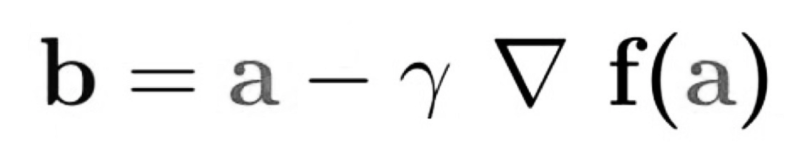

In [124]:
def gradient_descent(features, labels, weights, lr):
    N = len(features)

    predictions = predict(features, weights)
    gradient = np.dot(features.T,  predictions - labels)
    gradient /= N
    gradient *= lr
    weights -= gradient

    return weights

In [125]:
def decision_boundary(prob):
  return 1 if prob >= .5 else 0

def classify(predictions):
  decision_boundary = np.vectorize(decision_boundary)
  return decision_boundary(predictions).flatten()

In [137]:
def train(features, labels, weights, lr, iters):
    loss_history = []

    for i in range(iters):
        weights = gradient_descent(features, labels, weights, lr)

        #Calculate error for auditing purposes
        loss = loss_function(features, labels, weights)
        loss_history.append(loss)

        # Log Progress
        if i % 100 == 0:
            print (f"iter: {i} loss: {loss}")

    # return weights, loss_history

# Test log regression


In [138]:
from sklearn.datasets import load_breast_cancer
import torch

dataset = load_breast_cancer()

In [139]:
w = torch.zeros(569)

x = dataset.data[:, -1]
y = dataset.target

In [140]:
train(x, y, w, 0.01, 500)

iter: 0 loss: 0.6926699513103111
iter: 100 loss: 0.669766011700728
iter: 200 loss: 0.6647874436305496
iter: 300 loss: 0.6634014695061405
iter: 400 loss: 0.6629463607832364


# Sklearn LogRegression

In [141]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [142]:
x = np.array(dataset.data[:, -1]).reshape(-1, 1)
y = np.array(dataset.target)

In [147]:
model = LogisticRegression(solver='liblinear', C=5.0, random_state=0)
model.fit(x, y)

LogisticRegression(C=5.0, random_state=0, solver='liblinear')

In [148]:
p_pred = model.predict_proba(x)
y_pred = model.predict(x)
score_ = model.score(x, y)
conf_m = confusion_matrix(y, y_pred)
report = classification_report(y, y_pred)

In [149]:
print('report:', report, sep='\n')

report:
              precision    recall  f1-score   support

           0       1.00      0.01      0.02       212
           1       0.63      1.00      0.77       357

    accuracy                           0.63       569
   macro avg       0.81      0.50      0.40       569
weighted avg       0.77      0.63      0.49       569



In [150]:
print('score_:', score_, end='\n\n')

score_: 0.6309314586994728

